# FastFlow Inference
This notebook trains and evaluates a FastFlow model for anomaly detection.  Design tenants include high visibility on image data and model performance.  The goal is to provide a comprehensive framework for developing anomaly detection models, while explaining the code along the way.

### Contents
1. [Setup Variables](#setup-variables)
2. [Setup MLFLow Logging](#setup-mlflow-logging)
3. [Data Preparation](#data-preparation)
4. [Training the Model](#training-the-model)
5. [Model Evaluation](#model-evaluation)
6. [Visualize a Single Prediction](#visualize-a-single-prediction)
7. [Predict and Visualize the Dataset](#predict-and-visualize-the-dataset)

## Setup Variables

<small>[Back to Top](#contents)</small>

In [ ]:
import os
import logging
from dotenv import load_dotenv
from pytorch_lightning import seed_everything

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

load_dotenv("../../secrets.env")
load_dotenv("../../config.env")

ENVIRONMENT = os.getenv("ENVIRONMENT", "DEVELOPMENT")

logging.info(f"Running in {ENVIRONMENT} environment")

if ENVIRONMENT == "PRODUCTION":
    MLFLOW_URI = os.getenv('MLFLOW_URI')
else:
    MLFLOW_URI = "http://mlflow-mlflow"

if MLFLOW_URI is None:
    logging.warning("MLFLOW_URI not found in environment variables. MLFlow logging will not be enabled.")

# Data selection
bucket_name = "mvtechad"
category = "cable"
cache_directory = "s3cache"

# Set seed for reproducibility
seed_everything(42)

## Setup MLFLow Logging

<small>[Back to Top](#contents)</small>

In [ ]:
# Setup MLFlow Logging

if MLFLOW_URI is not None:
    logging.info(f"MLFLOW_URI found: {MLFLOW_URI}")
    import mlflow

experiment_name = f"{category}_fastflow_experiment"
mlflow.set_tracking_uri(MLFLOW_URI)
mlflow.set_experiment(experiment_name)

## Data Preparation

We'll use our s3data library to download/cache the data from our S3 bucket. This module expects a directory structure similar to the MVTechAD dataset. Then we'll use the anomalib Folder datamodule to hold our dataset.

### What is a DataLoader and what is a DataModule?

**DataLoader:**

- A PyTorch `DataLoader` is a utility that loads data from a dataset and serves it in batches to your model during training or inference.
- It handles shuffling, batching, and parallel loading using multiple workers.
- Example: `DataLoader(dataset, batch_size=32, shuffle=True)`

**DataModule:**

- A `DataModule` (from PyTorch Lightning or similar frameworks) is a higher-level abstraction that organizes all data-related steps for a project.
- It encapsulates dataset preparation, setup, and provides ready-to-use DataLoaders for training, validation, and testing.
- This helps keep data logic separate from model logic and makes experiments more reproducible.
- Example: `datamodule.train_dataloader()` returns a DataLoader for training data.

<small>[Back to Top](#contents)</small>

In [74]:
from s3dataset import s3data
from anomalib.data import Folder
import os

s3data.set_aws_config(
    access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
    secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY'),
    region_name=os.getenv('AWS_REGION_NAME')
)

images, class_names, labels, tags = s3data.get_dataset(bucket_name=bucket_name, prefix=category, limit=1000, cache_dir=cache_directory)

# Dynamically find anomaly directories under test/
test_dir = os.path.join(cache_directory, category, 'test')
abnormal_dirs = [
    os.path.join('test', d)
    for d in os.listdir(test_dir)
    if os.path.isdir(os.path.join(test_dir, d)) and d != 'good'
]
print(f"Found abnormal directories: {abnormal_dirs}")

mask_dir = os.path.join(cache_directory, category, 'ground_truth')
mask_dirs = [
    os.path.join('ground_truth', d)
    for d in os.listdir(mask_dir)
    if os.path.isdir(os.path.join(mask_dir, d))
]

print(f"Found mask directories: {mask_dirs}")

datamodule = Folder(
    name=category,
    root=os.path.join(cache_directory, category),
    normal_dir=os.path.join('train', 'good'),
    mask_dir=mask_dirs,
    normal_test_dir=os.path.join('test', 'good'),
    abnormal_dir=abnormal_dirs,
)

print("Preparing data...")
datamodule.prepare_data()

print(f"Setting up '{datamodule.name}' datasets...")
datamodule.setup()

print(f"Training samples: {len(datamodule.train_data)}")
print(f"Test samples: {len(datamodule.test_data)}")

Fetching dataset from S3 bucket: mvtechad
Downloaded: 0 Cached: 355 Ignored: 0
Found abnormal directories: ['test\\broken_large', 'test\\broken_small', 'test\\contamination']
Found mask directories: ['ground_truth\\broken_large', 'ground_truth\\broken_small', 'ground_truth\\contamination']
Preparing data...
Setting up 'bottle' datasets...
Training samples: 209
Test samples: 42


## Training the Model
- Callbacks are used to log metrics and model checkpoints during training. This allows for stopping training early if the model is not improving.
- Model checkpoints allow you to resume training from a specific point or to evaluate the model's performance at different stages.

<small>[Back to Top](#contents)</small>

In [ ]:
from anomalib.models import Fastflow
from anomalib.engine import Engine
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from torchvision.transforms import v2

# Custom callback to log checkpoints to MLflow
import lightning.pytorch as pl
class MLflowCheckpointLogger(pl.callbacks.Callback):
    def on_save_checkpoint(self, trainer, pl_module, checkpoint):
        logging.info("Saving checkpoint to MLflow")
        # Find the last checkpoint path from ModelCheckpoint callback
        for cb in trainer.callbacks:
            if isinstance(cb, ModelCheckpoint):
                ckpt_path = cb.last_model_path
                if ckpt_path and os.path.exists(ckpt_path):
                    mlflow.log_artifact(ckpt_path)

model = Fastflow(
    backbone="resnet18",  # or resnet50
    pre_trained=True,
    evaluator=True
)

callbacks = [
    ModelCheckpoint(
        monitor="train_loss", 
        dirpath="checkpoints",
        filename="epoch_{epoch}_step_{step}",
        auto_insert_metric_name=False,
    ),
    EarlyStopping(
        monitor="train_loss",
        patience=3,
    ),
    MLflowCheckpointLogger(),
]

engine = Engine(
    callbacks=callbacks,
    logger=None,  # Disable AnomalibMLFlowLogger since there was a bug with artifact logging. We'll use MLflow directly
    accelerator="auto", 
    devices=1, 
    max_epochs=4,
)
mlflow.end_run() #in case there is a run already active 
mlflow_run = mlflow.start_run(tags={"model": "fastflow"}) 
mlflow.log_param("category", category)
mlflow.log_param("backbone", "resnet18")
mlflow.log_param("max_epochs", 4)



In [ ]:
logging.info("Training the model")

engine.fit(
    model=model,
    datamodule=datamodule,
)

In [ ]:
logging.info("Evaluating model")

results = engine.validate(model=model, datamodule=datamodule)

metrics_dict = {}
if isinstance(results, list) and results and isinstance(results[0], dict):
    metrics_dict['image_AUROC'] = float(results[0].get('image_AUROC', float('nan')))
    metrics_dict['pixel_AUROC'] = float(results[0].get('pixel_AUROC', float('nan')))

if metrics_dict:
    logging.info(f"Logging metrics to MLflow: {metrics_dict}")
    mlflow.log_metrics(metrics_dict)
else:
    logging.warning("No metrics found to log. Is the evaluator working properly?")

logging.info("Training and evaluation complete")

In [ ]:
logging.info("Saving the model")

model_name = f"{category} - FastFlow"
mlflow.pytorch.log_model(model, name=model_name)

# Visualize a Single Prediction

<small>[Back to Top](#contents)</small>

In [68]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from anomalib.data import PredictDataset

# pandas dataframe
samples = datamodule.test_data.samples

# Get a random row from the samples
sample = samples.sample(1)
# Extract the image path as a string (assumes column is named 'image_path')
path = str(sample.iloc[0]["image_path"])

# inference_dataset = PredictDataset(path=path, image_size=(512, 512))
# inference_dataloader = DataLoader(dataset=inference_dataset, persistent_workers=True, num_workers=4)

predictions = engine.predict(model=model, data_path=path)  #You can also point to a folder with image or a single image instead of passing a dataset

2025-08-10 12:00:37,572 - anomalib.engine.engine - WARNING - ckpt_path is not provided. Model weights will not be loaded.
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
2025-08-10 12:00:37,575 - lightning.pytorch.utilities.rank_zero - INFO - The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
c:\Repos\spencershepard@hotmail.com\MLOps-Precision-Lens\models\anomaly\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Repos\spencershepard@hotmail.com\MLOps-Precision-Lens\models\anomaly\.ve

Predicting: |          | 0/? [00:00<?, ?it/s]

2025-08-10 12:00:37,729 - anomalib.visualization.image.item_visualizer - WARNING - Field 'gt_mask' is None in item. Skipping visualization.


Image Shape: torch.Size([1, 3, 256, 256]),
Anomaly Map Shape: torch.Size([1, 256, 256]), 
Predicted Mask Shape: torch.Size([1, 256, 256])
Image Shape: torch.Size([1, 3, 256, 256])
Image dims: 4


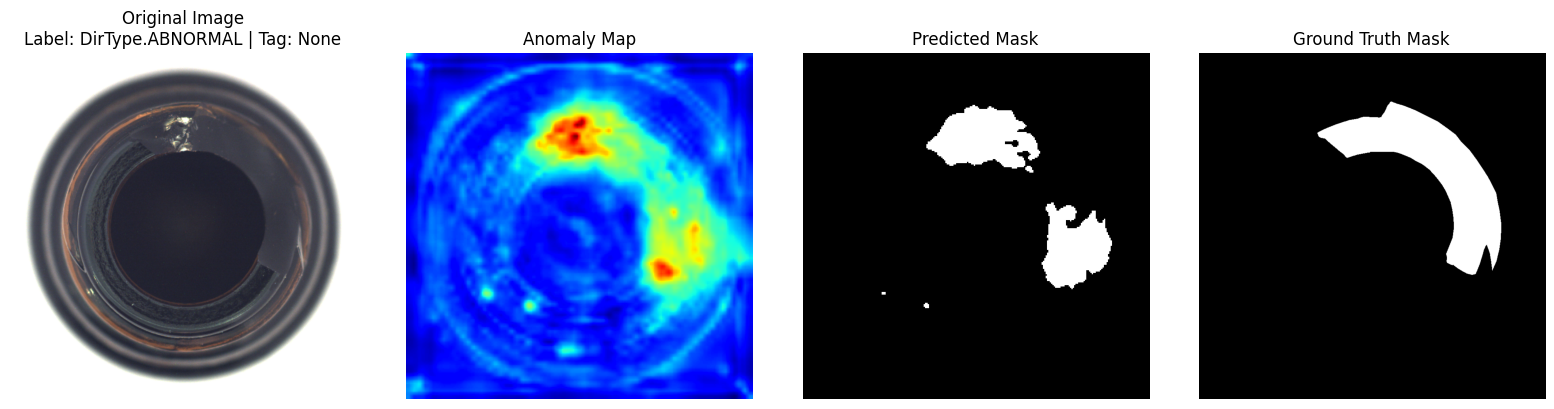

Path: C:\Repos\spencershepard@hotmail.com\MLOps-Precision-Lens\models\anomaly\s3cache\bottle\test\broken_large\009.png
Pred Score: tensor([[0.9462]])


In [69]:
import matplotlib.pyplot as plt
from PIL import Image

original_img = Image.open(path)
mask = Image.open(str(sample.iloc[0]["mask_path"]))

# Extract the first prediction result
pred = predictions[0]

print(
    f'Image Shape: {pred.image.shape},\n'
    f'Anomaly Map Shape: {pred.anomaly_map.shape}, \n'
    f'Predicted Mask Shape: {pred.pred_mask.shape}',
)

# Extract label and tag from the sample DataFrame
label = sample.iloc[0]["label"] if "label" in sample.columns else None
tag = sample.iloc[0]["tag"] if "tag" in sample.columns else None

# Create subplots for image, anomaly map, and predicted mask
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
img = pred.image
print(f"Image Shape: {img.shape}")
print(f"Image dims: {img.dim()}")
if img.dim() == 4:
    # Batch of images, select the first one
    img = img[0]
if img.dim() == 3:
    img = img.permute(1, 2, 0).cpu().numpy()  # reorders the dimensions of the tensor from `[C, H, W]` to `[H, W, C]`
elif img.dim() == 2:
    img = img.cpu().numpy()
else:
    raise ValueError(f"Unexpected image shape after batch selection: {img.shape}")

anomaly_map = pred.anomaly_map
if anomaly_map.dim() > 2:
    anomaly_map = anomaly_map[0]
anomaly_map = anomaly_map.squeeze().cpu().numpy()

pred_mask = pred.pred_mask
if pred_mask.dim() > 2:
    pred_mask = pred_mask[0]
pred_mask = pred_mask.squeeze().cpu().numpy()


title_str = "Original Image"
title_str += f"\nLabel: {label} | Tag: {tag}"

axs[0].imshow(original_img)
axs[0].set_title(title_str)
axs[0].axis('off')
axs[1].imshow(anomaly_map, cmap="jet")
axs[1].set_title("Anomaly Map")
axs[2].imshow(pred_mask, cmap="gray")
axs[2].set_title("Predicted Mask")
axs[3].imshow(mask, cmap="gray")
axs[3].set_title("Ground Truth Mask")

for ax in axs: ax.axis('off')
plt.tight_layout()
plt.show()
print(f"Path: {path}")
print(f"Pred Score: {pred.pred_score}")


## Predict and Visualize the Dataset
We will use the trained FastFlow model to make predictions on the entire dataset and visualize the results using Voxel FiftyOne.

<small>[Back to Top](#contents)</small>

In [83]:
import fiftyone as fo
from fiftyone.core.labels import Classification, Segmentation
import numpy as np

images, class_names, labels, tags = s3data.get_dataset(bucket_name=bucket_name, prefix=category, limit=1000, cache_dir=cache_directory)
# Normalize all image paths to absolute paths for consistent lookup
def norm_path(p):
    return os.path.normcase(os.path.abspath(p))

dataset_dict_by_path = {
    norm_path(img): {
        "image": img,
        "class_name": class_names[i],
        "label": labels[i],
        "tags": tags[i]
    }
    for i, img in enumerate(images)
}

print(f"Total images to process: {len(images)}")
# Create FO dataset from images, class_names, labels, and tags
name = "my-labelled-dataset"
if fo.dataset_exists(name):
    fo.delete_dataset(name)
dataset = fo.Dataset(name=name)

predictions = engine.predict(model=model, datamodule=datamodule)
print(f"Batches of predictions made: {len(predictions)}")
# flatten batches
predictions = [item for batch in predictions for item in batch]
print(f"Total predictions made: {len(predictions)}")

for i, pred in enumerate(predictions):

    ## Important prediction attributes:
    # image (Image)
    # anomaly_map (Mask)
    # pred_score (tensor([[0.09]]))
    # pred_mask (Mask)
    # pred_label (tensor[False]))
    # image_path (['C:/...'])

    anomaly_map = pred.anomaly_map
    pred_score = float(pred.pred_score) if hasattr(pred, 'pred_score') else None
    pred_mask = pred.pred_mask
    image_path = pred.image_path.item() if isinstance(pred.image_path, list) else pred.image_path
    pred_label = bool(pred.pred_label.item()) if hasattr(pred, 'pred_label') else None
    image = pred.image

    pred_mask = pred_mask.squeeze().cpu().numpy()

    norm_image_path = norm_path(image_path)
    tags = dataset_dict_by_path.get(norm_image_path, {}).get("tags", [])
    class_name = dataset_dict_by_path.get(norm_image_path, {}).get("class_name", "")
    label = dataset_dict_by_path.get(norm_image_path, {}).get("label", "")

    sample = fo.Sample(filepath=image_path, ground_truth=fo.Classification(label=label))

    if pred_score is not None:
        sample["pred_score"] = pred_score
    if pred_label is not None:
        sample["pred_label"] = pred_label
    if pred_mask is not None:
        sample["pred_mask"] = fo.Segmentation(mask=pred_mask.astype(np.uint8))

    dataset.add_sample(sample)

fo.launch_app(dataset)

Fetching dataset from S3 bucket: mvtechad
Downloaded: 0 Cached: 355 Ignored: 0
Total images to process: 355

Total images to process: 355


2025-08-10 12:33:14,349 - anomalib.engine.engine - WARNING - ckpt_path is not provided. Model weights will not be loaded.
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
2025-08-10 12:33:14,350 - lightning.pytorch.utilities.rank_zero - INFO - The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
2025-08-10 12:33:14,350 - lightning.pytorch.utilities.rank_zero - INFO - The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PrePr

Predicting: |          | 0/? [00:00<?, ?it/s]

Batches of predictions made: 2
Total predictions made: 42


Dataset:          my-labelled-dataset
Media type:       image
Num samples:      42
Selected samples: 0
Selected labels:  0
Session URL:      http://localhost:5151/